# Anomaly Detection for POS System

The business needs to know if there is a way to anticipate a failure in the POS system.

The data are the logs of POS system, in the **EzSystem.dbo.t_ezsystem_translog** table.

So, this document presents the analysis of the 30 min before each system error started, trying to understand that happened just before the system error ocurred.

The data to be created from this table is the percentage of transactions for each transaction type by:
 - Year
 - Month
 - Day
 - Weekday (Mon - Sun)
 - Hour
 - Minute

**In other words: A percentage transaction time series at hour level for each transaction type since 2019.**

The data also includes in which minutes a system error ocurred, and another column that indicates the 30 min before the system error began.

## Data Layout

The data created in SQL have these columns:

|  Column  |  Description  |
|:--------:|:-------------:|
|   Year   | Transaction date Year |
|  Month   | Transaction date Month |
|   Day    | Transaction date Day |
|   Hour   | Transaction date Hour |
| Minute   | Transaction date Minute |
|  Weekday | Transaction date Weekday (Monday - Sunday) |
|  transType | Transaction Type. Example: 301001-LN-Loan |
|  num_transactions | Number of transactions for each transaction type |
|  total_transactions | Number of transactions for each hour |
|  pct_transactions | % transactions for each transaction type ($\frac{NumTransactiones}{TotalTransactions}$) |
| ind_sys_error | System error indicator: 1 when system error happened |
| ind_sys_error_30min_before | System error indicator: 1 when system error happened 30 min before the start time |

# Libraries

In [59]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pymssql
import h2o
from plotnine import *
from dfply import * #dplyr para python
import datetime
import math

# Reading Data

## Historical Transactions

The data was created in a table on **Diego_DB**.

It can be read with _pymssql_ directly from SQL or reading it from a CSV.

Reading with _pymssql_

In [2]:
# Query
#qrl = """ SELECT * FROM Diego_DB.dbo.historic_transactions_pct_minute """

# Conenction
#conn = pymssql.connect(server = 'CHWN-DSX-DB02', user = 'Ezcorp\darias',password ='F@cil2018',database = 'Diego_DB')

# Read data
#df = pd.read_sql(qrl,conn)

Reading in CSV

In [3]:
df=pd.read_csv('/Users/darias/Documents/POS_Anomaly_detection/Data/historic_transactions_transType_minute_by_minute.csv',
               dtype={'year':np.str, 'month':np.str,'day':np.str,'hour':np.str, 'minute':np.str})

### Data Example

For a certain hour of a date, we can see the distribution of the transaction type percentage of transactions.

In [4]:
df[(df.year == '2019') & (df.month == '01') & (df.day == '02') & (df.hour == '09') & (df.minute == '01')]

year month day    weekday hour minute  \
4653     2019    01  02  wednesday   09     01   
214471   2019    01  02  wednesday   09     01   
463739   2019    01  02  wednesday   09     01   
615563   2019    01  02  wednesday   09     01   
810621   2019    01  02  wednesday   09     01   
859787   2019    01  02  wednesday   09     01   
1034859  2019    01  02  wednesday   09     01   
1036402  2019    01  02  wednesday   09     01   
1147141  2019    01  02  wednesday   09     01   
1483736  2019    01  02  wednesday   09     01   
1528832  2019    01  02  wednesday   09     01   
1651673  2019    01  02  wednesday   09     01   
1806359  2019    01  02  wednesday   09     01   
1916511  2019    01  02  wednesday   09     01   
2033285  2019    01  02  wednesday   09     01   
2136088  2019    01  02  wednesday   09     01   
2399502  2019    01  02  wednesday   09     01   
2592465  2019    01  02  wednesday   09     01   
2854873  2019    01  02  wednesday   09     01   
2910468  2019    01  02  wednesday   09     01   
2945448  2019    01  02  wednesday   09     01   
3024046  2019    01  02  wednesday   09     01   

                                transType  num_transactions  \
4653                       301001-LN-Loan                 2   
214471                 301003-PR-Purchase                 1   
463739      305001-CU-Add/Update Customer                32   
615563           308006-CB-Balance Drawer                 5   
810621      312001-EU-Add/Update Employee               391   
859787          302003-LY-Layaway Payment                 2   
1034859         318001-LN-Loan Redemption                 3   
1036402                  302004-RT-Return                 1   
1147141                   303001-CN-Count                13   
1483736            318036-LY-Drop Layaway                 3   
1528832          339001-AL-Customer Alert                 5   
1651673             308004-CB-Open Drawer                 2   
1806359             310003-IU-Update Item                19   
1916511              310004-SI-Split Item                10   
2033285         314004-LN-Loan Reactivate                 3   
2136088  315001-FN-Deposit/Transfer Funds                 8   
2399502             318002-LN-Extend Loan                28   
2592465            318006-LY-Layaway Paid                 1   
2854873              318030-AL-Loan Alert                 8   
2910468               318033-LN-Drop Loan                70   
2945448           318035-PR-Drop Purchase                31   
3024046       318053-LN-Drop One Day Loan                 2   

         total_transactions  pct_transactions  ind_sys_error  \
4653                    640          0.003125              0   
214471                  640          0.001563              0   
463739                  640          0.050000              0   
615563                  640          0.007812              0   
810621                  640          0.610938              0   
859787                  640          0.003125              0   
1034859                 640          0.004687              0   
1036402                 640          0.001563              0   
1147141                 640          0.020313              0   
1483736                 640          0.004687              0   
1528832                 640          0.007812              0   
1651673                 640          0.003125              0   
1806359                 640          0.029687              0   
1916511                 640          0.015625              0   
2033285                 640          0.004687              0   
2136088                 640          0.012500              0   
2399502                 640          0.043750              0   
2592465                 640          0.001563              0   
2854873                 640          0.012500              0   
2910468                 640          0.109375              0   
2945448                 640          0.048438              0   


Also we can verify that the sum of the pct of transactions is 1

In [5]:
sum(df[(df.year == '2019') & (df.month == '01') & (df.day == '02') & (df.hour == '09') & (df.minute == '01')]['pct_transactions'])

0.9999999999999999

# Data Engineering

## Create date-hour column

Create a column with: year, month, day, hour.

In python _datetime_

In [6]:
df['date'] = df['year'] + '-' + df['month'] + '-' + df['day'] + ' ' + df['hour'] + ':' + df['minute'] + ':00'

In [7]:
df['date'] = pd.to_datetime(df['date'])

## Cleaning Data

Years just in 2019 until July

In [8]:
df=df[(df.year=='2019')]

In [9]:
df=df[df['date']<='2019-06-30 23:59:59']

Leaving just transactions with at least 100 events

In [10]:
cts=pd.DataFrame(df.groupby(['transType'])['transType'].count().sort_values())
cts.columns = ['counts']
cts=cts[cts['counts']>=100]
representative_transactions = cts.index

In [11]:
df=df[df.transType.isin(representative_transactions)]

## Fixing Data

We are going to modify the data, doing this steps:
 - Information of 30 minutes before the start time for each system error
 - Sample information (1,000) of system without errors
 - Make the data in a columnar way: for each observation, a column with the pct of transactions for each transaction type, for each minute (of the 30 min), for system errors and for sample without system errors.

### 30 minutes before system errors info

Just data of the 30 min before the a system error started, in a columnar way for each of the 30 min

In [290]:
df_30min=(
df >>
    mask(X.ind_sys_error_30min_before == 1) >>
    group_by(X.transType, X.error_number) >>
    mutate(rank = X.date.rank(ascending=False)) >>
    ungroup()
).pivot_table(index=['error_number'],
                      columns=['transType', 'rank'],
                      values='pct_transactions',
                      #values='num_transactions',
                      aggfunc='mean').fillna(0)

In [291]:
df_30min=pd.DataFrame(df_30min.to_records())

### No system errors info

Samples of consecutive 30 min without system errors and without the 30 min before each error began.

In [292]:
# Array with all possible date + hour + minute
possible_minutes=(
df[df['hour'].isin(['09','10','11','12','13','14','15','16','17','18','19','20'])] >>
    mask(X.ind_sys_error == 0) >>
    mask(X.ind_sys_error_30min_before == 0) >>
    select(X.date) >>
    pull
).unique()

In [293]:
# Array with 30 min intervlas
interval_30min = np.repeat(range(math.trunc(possible_minutes.shape[0]/30)), 30)

In [294]:
# possible minutes with the same length of the 30 min intervlas
possible_minutes=possible_minutes[0:interval_30min.shape[0]]

In [295]:
# Data Frame with possible minutes and intervals
df_interval=pd.DataFrame({'date':possible_minutes,
              'intervals':interval_30min})

In [296]:
# Leave just intervlas in the same say
df_interval['day']=df_interval.date.dt.day
df_interval=(
df_interval >>
    group_by(X.intervals) >>
    mutate(min_day = X.day.min(),
           max_day = X.day.max()) >>
    ungroup() >>
    mask(X.min_day==X.max_day) >>
    select(X.date,X.intervals)
)

In [297]:
# Select a sample of 10,000
np.random.seed(69)
samp=np.random.choice(list(df_interval.intervals.unique()),2000)

In [298]:
# Select 30 minutes interval of the sample
df_interval=df_interval[df_interval['intervals'].isin(samp)]

In [299]:
# Join the 30 min intervals to the date
df_zeros=(
df >>
    left_join(df_interval,by='date')
)

In [300]:
# Leave just minutes selectioned as zero sample
df_zeros=df_zeros.dropna()

In [301]:
# Modify the data in a column way
df_zeros=(
df_zeros >>
    group_by(X.transType, X.intervals) >>
    mutate(rank = X.date.rank(ascending=False)) >>
    ungroup()
).pivot_table(index=['intervals'],
                      columns=['transType', 'rank'],
                      values='pct_transactions',
                      #values='num_transactions',
                      aggfunc='mean').fillna(0)

In [302]:
df_zeros=pd.DataFrame(df_zeros.to_records())

In [303]:
df_zeros=df_zeros.rename(columns = {'intervals':'error_number'})

### Same columns

To concat both data frames, we need both data frames with the same columns.

So, we are going to create the columns that are in the df_30min and not in the df_zeros, with 0 in all rows, and the same in the other way.

In [304]:
# Columns in df_zeros and not in df_30min
a=set(df_30min.columns.values).difference(set(df_zeros.columns.values))
a=list(a)

# Columns in df_30min and not in df_zeros
b=set(df_zeros.columns.values).difference(set(df_30min.columns.values))
b=list(a)

In [305]:
# Add columns needed in df_30min
for col in a:
    df_30min[col] = 0

In [306]:
# Add columns needed in df_zeros
for col in b:
    df_zeros[col] = 0

In [307]:
# Concat both data frames
df_full=pd.concat([df_30min, df_zeros], ignore_index=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [308]:
df_full=df_full.fillna(0)

In [309]:
## Create error indicator
df_full=(
df_full >>
    mutate(ind_error = if_else(X.error_number.str[:5]=='error',1,0))
)

In [313]:
## Save data
df_full.to_csv('/Users/darias/Documents/POS_Anomaly_detection/historic_30min_before_zerosample.csv')
#df_full.to_csv('/Users/darias/Documents/POS_Anomaly_detection/historic_30min_before_zerosample_num_trans.csv')

# GBM Model

A GBM will be fitted to obtain the most important features, and also to try to find some insights that predicts a possible new system error.

## Initiate H2O

Inititate H2O, indicating the memory to use

In [235]:
h2o.init(max_mem_size = "13G", nthreads=-1, strict_version_check = False)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T/tmpq1oih1ay
  JVM stdout: /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T/tmpq1oih1ay/h2o_darias_started_from_python.out
  JVM stderr: /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T/tmpq1oih1ay/h2o_darias_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       America/Mexico_City
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.1
H2O cluster version age:    7 days, 15 hours and 41 minutes
H2O cluster name:           H2O_from_python_darias_g03vgk
H2O cluster total nodes:    1
H2O cluster free memory:    13 Gb
H2O cluster total cores:    12
H2O cluster allowed cores:  12
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.1 final
--------------------------  ---------------------------------------------------

## Create H2O Data

Create a H2O Data Frame

In [236]:
df_h2o=h2o.H2OFrame(df_full)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [237]:
df_h2o['ind_error']=df_h2o['ind_error'].asfactor()

## Split Data

Split in _train & test_

In [238]:
train, test = df_h2o.split_frame(ratios=[0.8], seed=1234)

## X & Y

Lists with X & y

In [239]:
x=list(df_full.iloc[:,range(df_full.shape[1]-2)].columns.values)
y='ind_error'

## Grid

Finding the best metaparameter

In [240]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [241]:
hyper_parameters = {'ntrees': [800,900],
                    'col_sample_rate_per_tree': [0.2, 0.5, 0.7]}

search_criteria = { 'strategy': "RandomDiscrete",
                    'seed': 42,
                    'stopping_metric': "AUC", 
                    'stopping_tolerance': 0.01,
                    'stopping_rounds': 2 }

In [242]:
grid_gbm=H2OGridSearch(H2OGradientBoostingEstimator(),
                       hyper_parameters,
                       grid_id="random_plus_manual",
                       search_criteria=search_criteria)

In [243]:
grid_gbm.train(x=x,
               y=y,
               training_frame=train,
               #ntrees=200,
               seed=1,
               nfolds=2,
               learn_rate=0.001,
               max_depth=5,
               balance_classes=True)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [244]:
grid_gbm_list=grid_gbm.get_grid(sort_by='auc', decreasing=True)
grid_gbm_list

    col_sample_rate_per_tree ntrees                   model_ids  \
0                        0.2    800  random_plus_manual_model_2   
1                        0.2    900  random_plus_manual_model_3   
2                        0.5    800  random_plus_manual_model_5   
3                        0.5    900  random_plus_manual_model_6   
4                        0.7    900  random_plus_manual_model_4   
5                        0.7    800  random_plus_manual_model_1   

                  auc  
0  0.7948088693844555  
1  0.7943469222773992  
2  0.7268160295646149  
3   0.721359279362513  
4  0.6402586903799515  
5  0.6121954036262849  


## Best Model

Best model of all created in the grid

In [253]:
best_gbm = grid_gbm_list.models[0]

Save the model

In [254]:
h2o.save_model(model=best_gbm,
               path='/Users/darias/Documents/POS_Anomaly_detection/H2O_models',
               force=True)

'/Users/darias/Documents/POS_Anomaly_detection/H2O_models/random_plus_manual_model_2'

Load model if neccesary

In [39]:
#best_gbm = h2o.load_model('/Users/darias/Documents/POS_Anomaly_detection/H2O_models/random_plus_manual_model_2')

## Variable Importance

In [247]:
imp=best_gbm.varimp()
imp=pd.DataFrame(imp)

In [248]:
imp=(
 imp >>
    rename(variable            = 0,
           relative_importance = 1,
           scaled_importance   = 2,
           percentage          = 3)
)

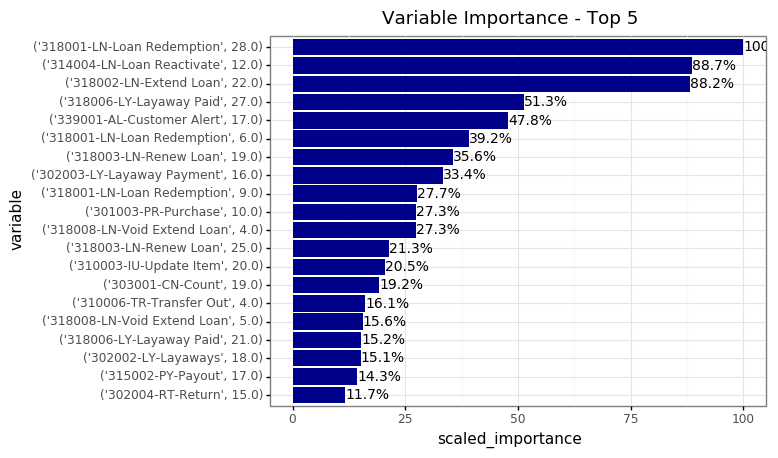

<ggplot: (-9223372029288002507)>

In [316]:
(
 imp.head(20) >>
    mutate(scaled_importance = X.scaled_importance*100) >>
    mutate(scaled_importance = X.scaled_importance.round(1)) >>
    ggplot() +
    geom_bar(aes(x='variable', y='scaled_importance'), stat='identity', fill='darkblue') +
    ggtitle('Variable Importance - Top 5') +
    scale_x_discrete(limits = imp.head(20) >> arrange(X.relative_importance) >> select(X.variable) >> pull) +
    theme(axis_text_x=element_text(angle=90, face='bold', size=10),
          axis_text_y=element_text(face='bold', size=10)) +
    theme_bw() +
    coord_flip() +
    geom_text(aes(x='variable',y='scaled_importance',label='scaled_importance'), ha='left', format_string='{}%', size = 10)
)

## AUC

In [250]:
perf_train=best_gbm.model_performance(train)
perf_test=best_gbm.model_performance(test)

In [251]:
ll={'desc':['Train', 'test'],'Coeficiente':[perf_train.auc(),
                                                     perf_test.auc()]}
ll=pd.DataFrame(ll)

orden_ll=(
 ll >>
    select('desc') >>
    pull
)

(
 ll >>
    mutate(Coeficiente = X.Coeficiente.round(2)) >>
    ggplot() +
    geom_bar(aes(x='desc',y='Coeficiente'),stat='identity',fill='darkblue') +
    scale_x_discrete(limits = orden_ll) +
    geom_text(aes(x='desc', y='Coeficiente', label='Coeficiente'), va='bottom') +
    theme_bw() +
    ggtitle('AUC')
)

<ggplot: (-9223372029275627902)>

## Confussion Matrix

In [255]:
best_gbm.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0054883426481114085: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      289  13   0.043    (13.0/302.0)
1      2    2    0.5      (2.0/4.0)
Total  291  15   0.049    (15.0/306.0)

## Performance

In [256]:
best_gbm.model_performance(test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.012958635546029856
RMSE: 0.11383600285511547
LogLoss: 0.07376797461244668
Mean Per-Class Error: 0.2715231788079471
AUC: 0.7582781456953642
pr_auc: 0.05741706570060404
Gini: 0.5165562913907285
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0054883426481114085: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      289  13   0.043    (13.0/302.0)
1      2    2    0.5      (2.0/4.0)
Total  291  15   0.049    (15.0/306.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00548834   0.210526  14
max f2                       0.00548834   0.322581  14
max f0point5                 0.00694041   0.178571  5
max accuracy                 0.00890058   0.98366   0
max precision                0.00694041   0.166667  5
max recall                   0.00348138   1         176
max specificity              0.00890058   0.996689  0
max absolute_mcc             0.00548834   0.240388  14
max min_per_class_accuracy   0.00375631   0.665563  103
max mean_per_class_accuracy  0.00548834   0.728477  14

Gains/Lift Table: Avg response rate:  1.31 %, avg score:  0.38 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0130719                   0.00757891         0        0                  0                0.00815902  0                           0.00815902          0               0                          -100     -100
    2        0.0228758                   0.00651662         25.5     10.9286            0.333333         0.0068663   0.142857                    0.007605            0.25            0.25                       2450     992.857
    3        0.0326797                   0.00606974         0        7.65               0                0.00622014  0.1                         0.00718954          0               0.25                       -100     665
    4        0.0424837                   0.005881           0        5.88462            0                0.00599464  0.0769231                   0.00691379          0               0.25                       -100     488.462
    5        0.0522876                   0.00518116         25.5     9.5625             0.333333         0.00540773  0.125                       0.00663141          0.25            0.5                        2450     856.25
    6        0.101307                    0.00464389         0        4.93548            0                0.00480203  0.0645161                   0.00574622          0               0.5                        -100     393.548
    7        0.150327                    0.00430021         0        3.32609            0                0.00444534  0.0434783                   0.00532202          0               0.5                        -100     232.609
    8        0.202614                    0.00402975         0        2.46774            0                0.00416921  0.0322581                   0.00502452          0               0.5                        -100     146.774
    9        0.300654                    0.00381409         0        1.66304            0                0.00393012  0.0217391                   0.00466765          0               0.5                        -100     66.3043
    10       0.401961                    0.00367926         2.46774  1.86585            0.0322581        0.00374003  0.0243902                   0.00443386          0.25            0.75                       146.774  86.5854
    11       0.5                         0.00358901         0        1.5                0                0.00363554  0.0196078                   0.00427733          0               0.75                       -100     50
    12       0.601307                    0.00345064         2.46774  1.66304            0.0322581        0.00351686  0.0217391                   0.0041492           0.25            1                          146.774  66.3043
    13       0.699346                    0.00338444         0        1.42991            0                0.0034069   0.0186916                   0.00404514          0               1                          -100     42.9907
    14       0.800654                    0.00333528         0        1.24898            0                0.00336222  0.0163265                   0.00395873          0               1                          -100     24.898
    15       0.898693                    0.00328051         0        1.11273            0                0.00330299  0.0145455                   0.0038872           0               1                          -100     11.2727
    16       1                           0.00322811         0        1                  0                0.00326538  0.0130719                   0.0038242           0         